# Klasteriranje

Usporedno s razvojem digitalizacije podaci se počinju prikupljati velikom brzinom, pa je obrada skupljenih podataka postala znatno teža. Kako bi se uočila slična svojstva među podacima i otkrile neke nove karakteristike, prirodno se pojavila potreba za grupiranjem podataka. Danas je jedna je od najčešćih tehnika analize podataka. Svoje primjene nalazi u raznim područjima znanosti kao što su strojno učenje, statistika, fizika, biologija, itd. 
<br><br>
Osnovni cilj klasteriranja je grupiranje podataka prema zadanom kriteriju uz postizanje velike sličnosti između podataka unutar iste grupe, a male sličnosti između podataka koji pripadaju različitim grupama. 

1. [Klasteriranje kao optimizacijski problem](#uvod)
2. [Klasterska analiza](#analiza)
    1. [Priprema podataka](#priprema) 
        1. [Normalizacija podataka](#normalizacija)
        2. [Skaliranje podataka](#skaliranje)
    2. [Mjere sličnosti za numeričke varijable](#slicnost)
    3. [Algoritmi klasteriranja](#algoritmi) 
        1. [Hijerarhijski algoritmi](#hijerarhijski)
        2. [Nehijerarhijski algoritmi](#nehijerarhijski)
    4. [Interpretacija rezultata](#rezultat)
4. [Definicije](#definicije)
3. [Bibliografija](#bibliografija)

In [105]:
#biblioteke korištene bilježnici
import math
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from scipy.stats import norm
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import scipy.cluster.hierarchy as sch

from sklearn.datasets.samples_generator import make_blobs 
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.express as px
import plotly.graph_objects as go

np.random.seed(1191237156)

<br> 
***
<br>

## 1. Klasteriranje kao optimizacijski problem <a name="uvod"></a>

Glavni problem klasterske analize je za dani skup podataka $\boldsymbol{U}$ odrediti podskupove $C$ koji su homogeni i/ili dobro separirani u odnosu na mjerene varijable. Takve podskupove $C$ nazivamo klasteri, a skup svih klastera $\boldsymbol{C} = \{ C_1, C_2, ..., C_k \}$ klastering.
<br><br>
Navedeni problem može se formulirati kao sljedeći optimizacijski problem. 

Odrediti klastering $\boldsymbol{C}$ za koji vrijedi $$ P(\boldsymbol{C^*}) = \min_{\boldsymbol{C}\in\phi}P(\boldsymbol{C}) $$

gdje je $\boldsymbol{C}$ klastering za dani skup podataka $\boldsymbol{U}$, $\phi$ skup svih mogučih klasteringa i 
$P: \phi\rightarrow \mathbb{R}$ funkcija kriterija.

Ako je skup klastering konačan, rješenje problema uvijek postoji. Međutim, budući da je taj skup obično vrlo velik nije jednostavno naći optimalno rješenje.

## 2. Klasterska analiza <a name="analiza"></a>

Koraci u rješavanju problema klasteriranja su: 
1. Priprema podataka. 
2. Odabir prikladne mjere sličnosti među podacima za zadani problem.
3. Odabir tipa i algoritma klasteriranja.
4. Interpretacija rezultata.

## 2.1 Priprema podataka <a name="priprema"></a>

Kako se grupiranje bazira na izračunavanju udaljenosti među mjerenjima, podaci moraju biti
u numeričkom obliku. Zato je potrebno sve nenumeričke podatke prikazati numerički.
Također, budući da se može dogoditi da su mjere podataka u različitim skalama potrebno ih je skalirati ili normirati.

U ovoj bilježnici promatrati ću podatke iz World happines baze podataka za 2018. godinu.

In [2]:
data = pd.read_csv("/home/petra/Radna površina/ms/2018.csv") 
data = data.dropna()
del data['Overall rank']
data.set_index('Country or region', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, Finland to Burundi
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Score                         155 non-null    int64  
 1   GDP per capita                155 non-null    int64  
 2   Social support                155 non-null    int64  
 3   Healthy life expectancy       155 non-null    int64  
 4   Freedom to make life choices  155 non-null    int64  
 5   Generosity                    155 non-null    int64  
 6   Perceptions of corruption     155 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 9.7+ KB


Prvo promotrimo kakva je veza među podacima u bazi preko toplinske karte (_eng._ heat map).

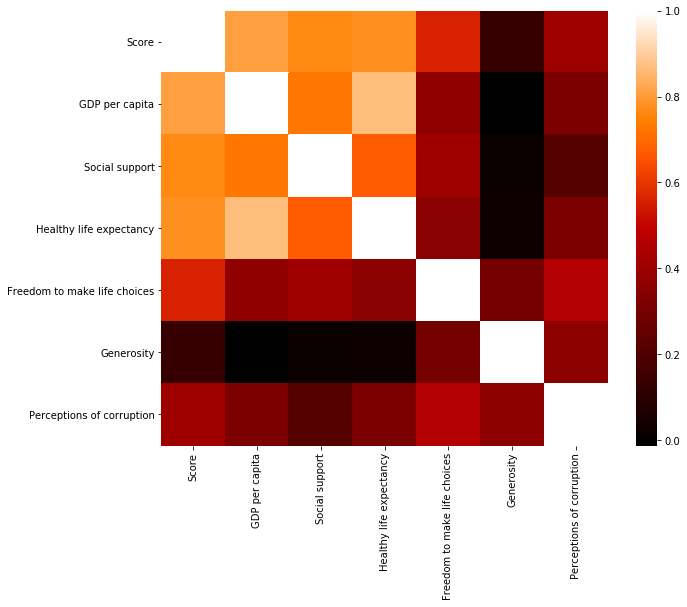

In [3]:
varijable = data[data.columns]
podaci = varijable.corr() 
plt.subplots(figsize=(10,8))
sns.heatmap(podaci,cmap='gist_heat')

In [4]:
data

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Country or region,,,,,,,
Finland,7632,1305,1592,874,681,202,393.0
Norway,7594,1456,1582,861,686,286,340.0
Denmark,7555,1351,1590,868,683,284,408.0
Iceland,7495,1343,1644,914,677,353,138.0
Switzerland,7487,1420,1549,927,660,256,357.0
...,...,...,...,...,...,...,...
Yemen,3355,442,1073,343,244,83,64.0
Tanzania,3303,455,991,381,481,270,97.0
South Sudan,3254,337,608,177,112,224,106.0


Vidimo da su u promatranoj bazi svi podaci o državama numerički. Međutim, već iz ovog ispisa vidimo da podaci nisu **normirani** ili normalizirani????. Zato je potrebno sve podatke dovesti u jednaki raspon (skaliranje) ili ih normalizirati.

### 2.1.1 Normalizacija podataka<a name="normalizacija"></a>

Normaliziacijom transformiramo podatke tako da se oni mogu uklopiti u normalnu distribuciju. Normalna razdioba je potpuno određena s parametrima: $$N(\sigma, m )$$

U grafičkom smislu pravac $x = m$, obzirom na kojeg je funkcija gustoće $$
f(x)=\frac {1}{\sigma\sqrt{2\pi}} {e}^{-\frac {1}{2} ( \frac {x-m}{\sigma})^2} 
$$
 simetrična, predstavlja pomak od ishodišta dok $\sigma$ ovisi spljoštenost grafa funkcije.

#### Grafički prikaz funkcije gustoće s naglaskom na interval [0, 1]

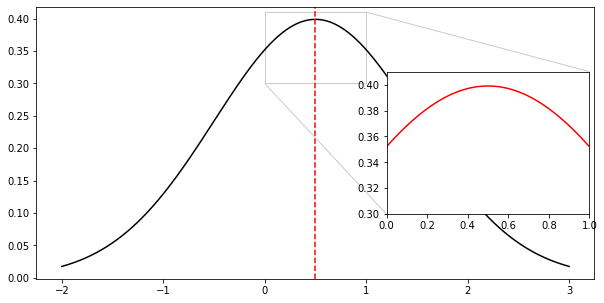

In [5]:
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
#import scipy.stats as stats
m = 0.5
var = 1
sigma = math.sqrt(var)
x = np.linspace(-2, 3, 500)
y = stats.norm.pdf(x, m, sigma)

#graf
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y, color='black')
plt.axvline(0.5, color='red', linestyle='dashed')

#uvećani dio grafa
axins = zoomed_inset_axes(ax, 2, loc='right')
axins.plot(x, y, color='red')
x1,x2,y1,y2 = 0, 1, 0.3,.41
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)

mark_inset(ax, axins, loc1=1, loc2=3, ec='0.8')
plt.show()

#### 3D prikaz normalne distribucije na intervalu [0, 1]

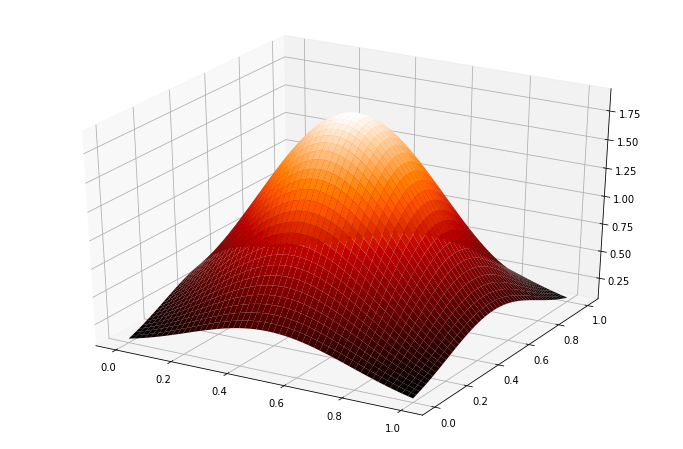

In [6]:
#from scipy.stats import multivariate_normal
#from mpl_toolkits.mplot3d import Axes3D

m_x = m_y = 0.5
x = y = np.linspace(0,1,500)

X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,)) #500x500x2
pos[:, :, 0] = X
pos[:, :, 1] = Y

rv = multivariate_normal([m_x, m_y], [[np.var(x), 0], [0, np.var(y)]])

#3D
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos), cmap='gist_heat')


#### Normalizacija podataka iz učitane baze na intervalu [0, 1]

In [7]:
#from scipy import linalg
def normaliziraj(data):
    normalizirana_baza=((data-data.min())/(data.max()-data.min()))
    return normalizirana_baza

normalizirana_baza = normaliziraj(data)
normalizirana_baza.head()

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Country or region,,,,,,,
Finland,1.000000,0.791389,0.968370,0.848544,0.940608,0.337793,0.859956
Norway,0.991961,0.882959,0.962287,0.835922,0.947514,0.478261,0.743982
Denmark,0.983711,0.819284,0.967153,0.842718,0.943370,0.474916,0.892779
Iceland,0.971018,0.814433,1.000000,0.887379,0.935083,0.590301,0.301969
Switzerland,0.969325,0.861128,0.942214,0.900000,0.911602,0.428094,0.781182


#### Prikaz histograma normaliziranih podataka izabranih stupaca i njihovih Gaussova krivulja

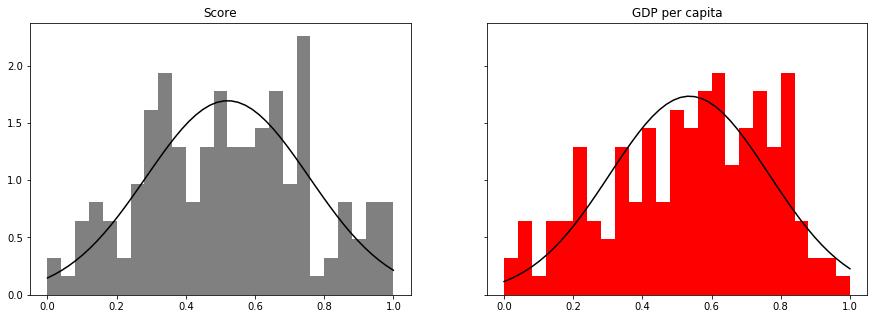

In [106]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,5))

ax[0].set_title('Score')
mu, std = norm.fit(normalizirana_baza['Score'])
ax[0].hist(normalizirana_baza['Score'], bins=25, density=True,  color='grey')
x = np.linspace(normalizirana_baza['Score'].min(), normalizirana_baza['Score'].max())
p = norm.pdf(x, mu, std)
ax[0].plot(x, p, color='black')

ax[1].set_title('GDP per capita')
mu, std = norm.fit(normalizirana_baza['GDP per capita'])
ax[1].hist(normalizirana_baza['GDP per capita'], bins=25, density=True, color='red')
x = np.linspace(normalizirana_baza['GDP per capita'].min(), normalizirana_baza['GDP per capita'].max())
p = norm.pdf(x, mu, std)
ax[1].plot(x, p, color='black')

### 2.1.2 Skaliranje podataka <a name="skaliranje"></a>

Dok smo normaliziacijom radikalnije transformirmirali podatke, skaliranjem podacima mijenjamo samo raspon.
Postoji više metoda za skaliranje podataka. Neke od njih su min-max skaliranje, standardizacija, binariziranje podataka...
Detaljnije ćemo promotriti rezultate dobivene min-max skaliranjem. 
<br>
Opća formula za min-max skaliranje na interval $[0, 1]$: $$x'= \frac {x-min(x)}{max(x)-min(x)}$$ gdje je $x$ originalna vrijednost, $x'$ skalirana.  

#### Minmax skaliranje podataka iz baze uz pomoć Pythonove scikit-learn biblioteke za strojno učenje

In [107]:
skalirana_baza = minmax_scale(data)
skalirana_baza = pd.DataFrame(skalirana_baza, index = data.index, columns = ['Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'])

Već prije je spomenuta razlika normalzacije i skaliranja podataka, a sada se u to možemo uvjeriti.

In [10]:
skalirana_baza['Score'].equals(normalizirana_baza['Score'])

False

#### Usporedba skaliranih i normaliziranih podataka

Međutim, interval u kojeg smo ugurali podatke ne daje prostora za prevelike razlike među rezultatima. To prikazuje sljedeći histogram usporedbe podataka na kojem se razlika golim okom ne može uočiti, već samo iz mješavine boja primjećujemo nihovo preklapanje.

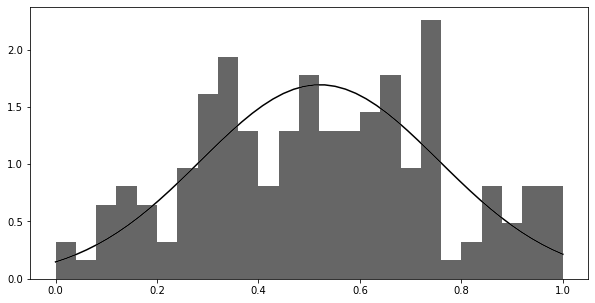

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('', fontsize=16, fontweight="bold")

mu, std = norm.fit(skalirana_baza['Score'])
ax.hist(normalizirana_baza['Score'], bins=25, density=True, alpha=0.6, color='white')
x = np.linspace(skalirana_baza['Score'].min(), skalirana_baza['Score'].max())
p = norm.pdf(x, mu, std)
ax.plot(x, p, color='white')
mu, std = norm.fit(normalizirana_baza['Score'])
ax.hist(normalizirana_baza['Score'], bins=25, density=True, alpha=0.6, color='black')
x = np.linspace(normalizirana_baza['Score'].min(), normalizirana_baza['Score'].max())
p = norm.pdf(x, mu, std)
ax.plot(x, p, color='black')

## 2.2 Mjere sličnosti za numeričke varijable<a name="slicnost"></a>

Neka su $x$ i $y$ opisane sa $n$ numeričkih varijabli
$$x = (x_1, x_2, ..., x_n)$$
$$y = (y_1, y_2, ..., y_n)$$
<br>
Neke od mjera za računanje sličnosti između $x$ i $y$ dane su sljedećim formulama:
* **Minkovski udaljenost**
$$ d(x,y) = \left(\sum_{i=1}^{n} \left|x_i-y_i\right|^r\right)^ \frac{1}{r} $$

    * **Euklidska udaljenost**
    $$ d(x,y) = \sqrt {\sum_{i=1}^{n} \left(x_i-y_i\right)^2} $$ 

    * **Manhattan udaljenost**
    $$ d(x,y) = \sum_{i=1}^{n} \left|x_i-y_i\right| $$ 

    * **Čerbišljeva udaljenost**
    $$ d(x,y) = \max_{i=1,...,n} \left|x_i-y_i\right| $$


## 2.3 Algoritmi klasteriranja <a name="algoritmi"></a>

Općenito, ne postoji objektivno ispravan algoritam klasteriranja. Određni algoritam može dati dobre rezultate na jednom skupu podataka, a loše ili nikakve na drugom, ovisno o dimenziji, strukturi i vrsti podataka.

Neke od karakteristika koje bi trebao imati dobar algoritam klasteriranja su sljedeće:
* sposobnost izvođenja na velikim skupovima podataka
* sposobnost izvođenja na različitim tipovima varijabli
* dobro nošenje s devijacijama
* neosjetljivost na redoslijed unosa podataka

Osnovna podjela algoritama za grupiranje podataka je na hijerarhijske i nehijerarhijske algoritme. 

### 2.3.1 Hijerarhijski algoritmi <a name="hijerarhijski"></a>

Hijerarhijski algoritmi su bazirani na ideji da su objekti više povezani s objektima koji su im bliži nego s onima koji su im udaljeniji.
<br><br>
Karakteristika takvih algoritama je da u više iteracija formiraju stablo na način da kreću od svih elemenata koje treba grupirati. U slijedećim iteracijama se formiraju grupe od više elemenata na temelju njihove međusobne udaljenosti, sve do tražene razine grupiranja. Ovi algoritmi neće proizvesti jedinstvenu podjelu skupa podataka, već hijerarhiju iz koje korisnik još treba odabrati odgovarajuće klastere. U općenitom slučaju složenost im je $\mathcal{O}(n^{3})$ što ih čini sporima za velike skupove podataka.
<br><br>
Stablo kojim se prikazuje raspored klastera nastalih hijerarhijskim klasteriranjem naziva se dendrogram. Sličnost između dva objekta u dendrogramu je reprezentirana visinom odnosno duljinom najnižeg unutarnjeg čvora kojeg dijele. U koordinatnom sustavu na osi ordinata vidi se visina na kojoj na pojedini klasteri spajaju, dok su na osi apscisa raspoređeni objekti.

##### Primjer dendograma za prvih 50 podataka baze

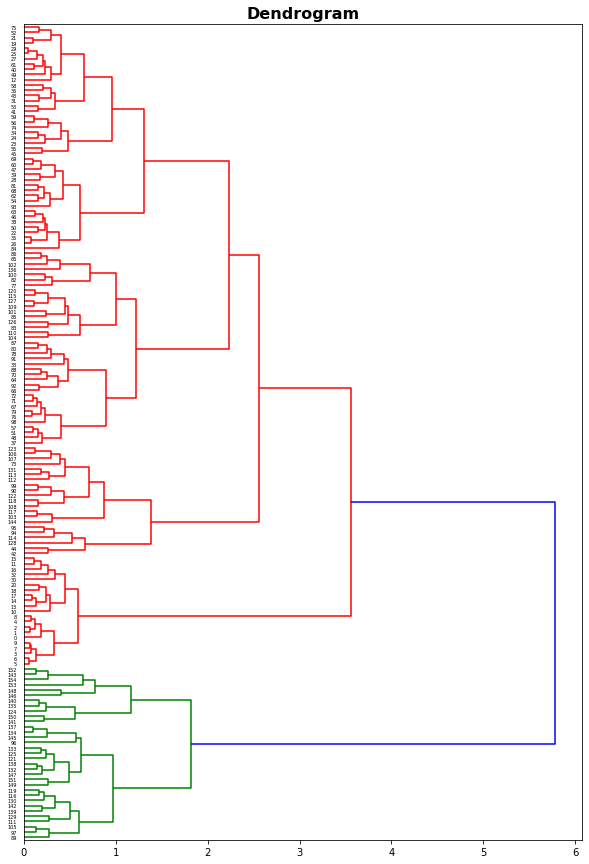

In [12]:
X = normaliziraj(data).iloc[:, [0, 1, 2, 3, 4, 5]].values
plt.figure(figsize=(10, 15))

dendrogram = sch.dendrogram( sch.linkage(X, method='ward'), orientation='right' )
plt.title('Dendrogram', fontsize=16, fontweight='bold')
plt.show()

### 2.3.1 Nehijerarhijski algoritmi <a name="nehijerarhijski"></a>

Kod nehijararhijskog klasteriranja svaki objekt se smješta u točno jedan od k disjunktnih klastera. Broj klastera mora biti unaprijed određen.
<br>
Najpoznatiji nehijerarhijski algoritam je algoritam k-srednjih vrijednosti (_eng._ k-means) kojim ćemo se baviti i u ovoj bilježnici.

### Algoritam k - sredina

Neka je $X=\{x_1, x_2,...,x_n\}$ skup podataka iz d-dimenzionalnog Euklidskog prostora $\mathbb{R}^d$. Algoritam patricionira skup X na $k$-klastera. Budući da je ovo nehijerarhijski algoritam znamo da varijabla $k$ mora biti unaprijed zadana. Algoritam svakom klasteru dodjeljuje predstavnika (centar) na sljedeći način:
$$ c_i=\frac {1}{\left|C_i\right|} \sum_{x \in C_i} x$$ gdje su $C_i \in \{1,2,...,k\}$ klasteri.
<br>
Osnovni algoritam $k$-sredina koristi Euklidsku metriku na $\mathbb{R}^d$: $$ F(C) = \sum_{i=1}^{k} \sum_{x \in C_i} \left\|x-c_i\right\|_2^2$$
Cilj algoritma je pronaći idealnu particiju tako da funkcija cilja ima minimalnu vrijednost. Dakle, mi tražimo najhomogenije klastere odnosno minimiziramo varijancu klastera.

#### Primjer algoritma

Promotrimo prvo _k-means_ algoritam Pythonove sklearn biblioteke na primjeru dvodimenzionalnog skupa izgeneriranih numeričkih podataka u slučaju da promatrana baza nije dobar ogledni primjerak. Broj centara, a time i klastera ograničili smo na 3.

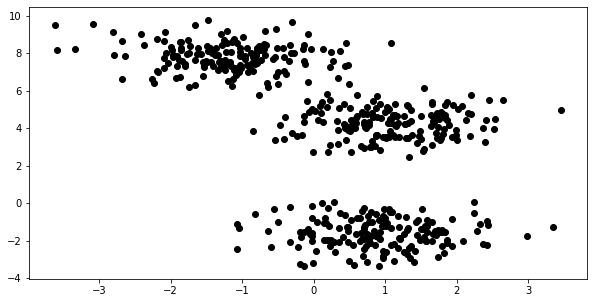

In [108]:
#from sklearn.datasets.samples_generator import make_blobs
fig = plt.figure(figsize=(10, 5))
X, y = make_blobs(n_samples=500, n_features=3,centers=3, cluster_std=0.8, random_state=0)
ax = plt.scatter(X[:, 0], X[:, 1], color='black')

##### 2D prikaz rezultata algoritma k-sredina

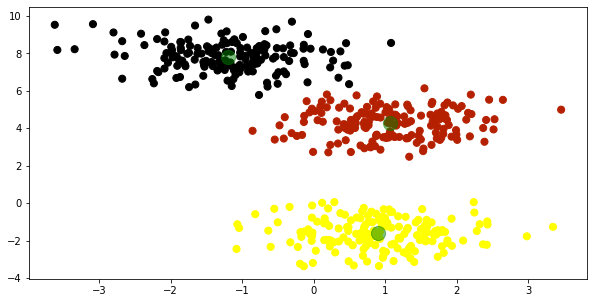

In [109]:
#from sklearn.cluster import KMeans
fig = plt.figure(figsize=(10, 5))
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='gnuplot')
centers = kmeans.cluster_centers_
ax = plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.5)
plt.show()

##### 3D prikaz rezultata algoritma k-sredina

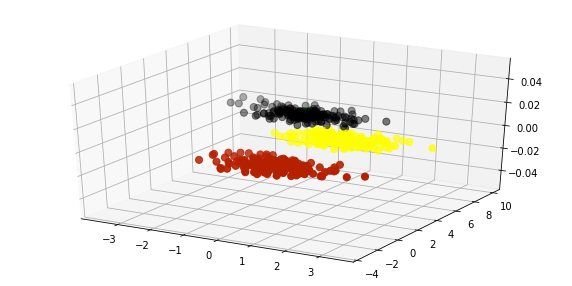

In [113]:
#from sklearn.cluster import KMeans
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(projection='3d')

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='gnuplot')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.5)
plt.show()

##### Primjena algoritma k-sredina na promatranu bazu

Prvo ćemo napisati funkciju koja klasterira podatke algoritmom k-sredina.

In [178]:
def Kmeans_happines(data, n_clusters):
    model = KMeans(n_clusters)
    model.fit(data)
    clusters = model.predict(data)
    centers = model.cluster_centers_
    return (clusters, centers)

Sada ćemo uz pomoć prethodne funkcije napisat funkciju koja crta raspodjelu podataka u zadani broj klastera. Podaci koji pripadaju istom klasteru biti će jednako obojani. Uz to svaki klaster računa i crta njegov centar.

In [179]:
def kMeans_happines_plot(data, n_clusters, var_1, var_2, var_1_index, var_2_index): #var_n_index je oznaka stupca u kojem se nalazi dana varijabla
    clusters, centers = Kmeans_happines(data.dropna(), n_clusters)

    plt.scatter(normaliziraj(data)[var_1], normaliziraj(data)[var_2], c=clusters, s=50, cmap='gnuplot')
    plt.scatter(centers[:, var_1_index], centers[:, var_2_index], c='g', s=200, alpha=1)
    plt.xlabel(var_1)
    plt.ylabel(var_2)

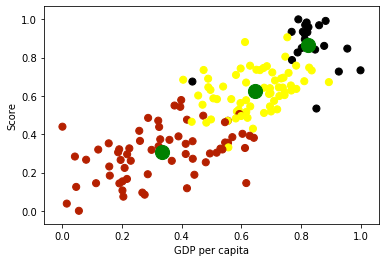

In [180]:
kMeans_happines_plot(normalizirana_baza, 3, 'GDP per capita', 'Score', 1, 0)

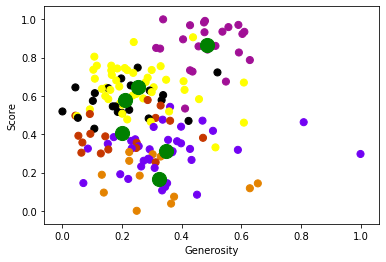

In [181]:
kMeans_happines_data(normalizirana_baza, 6, 'Generosity', 'Score', 5, 0)

<br><br>
***
<br>
<center>Petra Škrabo</center> 